# N02. Proyección del MEI (Índice Multivariado El Niño) replicando los comportamientos de periodos anteriores
Ya se tienen los datos guardados en MeiL, los cuales se descargaron del siguiente enlace:
https://psl.noaa.gov/enso/mei/data/meiv2.data


## 2.1. Carga paquetes

In [1]:
#*******************************************************************************       
# 2.1.1. Carga paquetes Python requeridos.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget
pd.options.plotting.backend = "plotly"

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import seaborn as sns

## 2.2. Lee MeiL

In [2]:
#*******************************************************************************
# 2.2.1. Lee el archivo meiL que está en formato parquet.
#*******************************************************************************
meiL = pd.read_parquet('parquet/meiL.parquet.gzip', engine='fastparquet')

## 2.3. Grafica MeiL

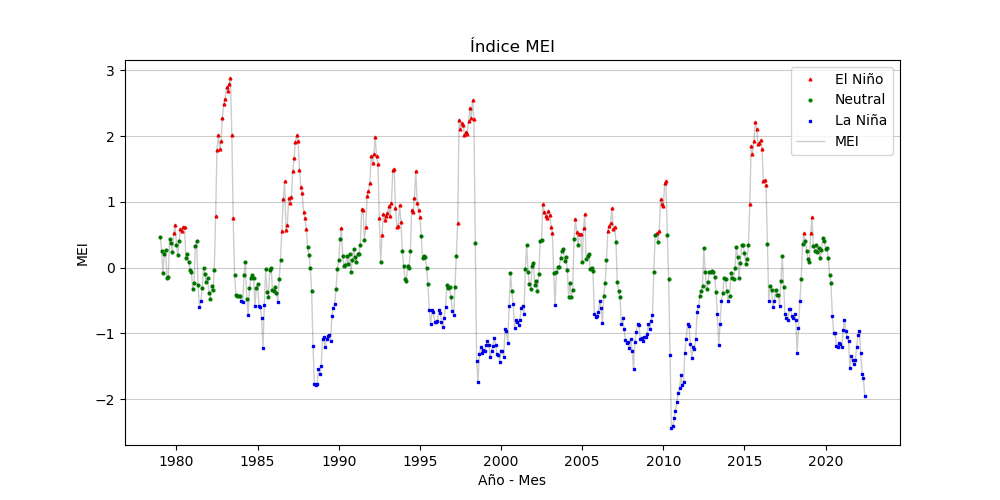

In [3]:
#*******************************************************************************
# 2.3.1 Grafica los índices meiL.
#*******************************************************************************
ind = np.arange(len(meiL))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#p1 = ax1(ind, eventosSTRCausaTotal.values)
ax1.set_title ('Índice MEI')
ax1.set_ylabel ('MEI')
ax1.set_xlabel ('Año - Mes')
#ax1.set_xticks(ind, labels=meiL.etiquetaX, rotation=90, fontsize=7)
#plt.xticks(rotation=90)
#
superior = 0.5
inferior = -0.5
nino = np.ma.masked_where(meiL.mei < superior, meiL.mei) #La máscara borra dato.
nina = np.ma.masked_where(meiL.mei > inferior, meiL.mei)
neutral = np.ma.masked_where((meiL.mei <= inferior) | (meiL.mei >= superior), meiL.mei)
ax1.plot(meiL.index, nino, 'r^', label='El Niño', markersize=2)
ax1.plot(meiL.index, neutral, 'go', label='Neutral', markersize=2)
ax1.plot(meiL.index, nina, 'bs', label='La Niña', markersize=2)
ax1.plot(meiL.index, meiL.mei, 'k-', label='MEI', linewidth=1, alpha=0.2)
plt.legend(loc='best')
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

## 2.4. Selecciona los posibles periodos de MEI que se repetirán en los próximos 78 meses

In [8]:
#*******************************************************************************
# 2.4.1 Crea meiT, con todos los periodos desde 1979-01 a 2022-06.
#*******************************************************************************
meiT = meiL 
meiT = meiT.reset_index()
#*******************************************************************************
#Identifica los periodos que se repetirán.
meiT[meiT['anioMes'] == '2010']
#meiT[378:456]
#*******************************************************************************
#2.4.2. Crea meiP1988_08, con 78 periodos.
#*******************************************************************************
meiP1988_08 = meiT[115:193].mei
meiP1988_08 = meiP1988_08.reset_index().mei
#meiP1988_08
#*******************************************************************************
#2.4.3. Crea meiP1998_08, con 78 periodos.
#*******************************************************************************
meiP1998_08 = meiT[235:313].mei
meiP1998_08 = meiP1998_08.reset_index().mei
#meiP1998_08
#*******************************************************************************
#2.4.4. Crea meiP2010_07, con 78 periodos.
#*******************************************************************************
meiP2010_07 = meiT[378:456].mei
meiP2010_07 = meiP2010_07.reset_index().mei
#meiP2010_07

In [9]:
#*******************************************************************************
# 2.4.5. Integra, las 3 series futuras.
#*******************************************************************************
meiTa = pd.DataFrame({'anioMes': pd.date_range(start='2022-07-01', \
    periods = 78, freq='MS'), 'mei': np.NaN})
meiTa['meiP1988_08'] = meiP1988_08
meiTa['meiP1998_08'] = meiP1998_08
meiTa['meiP2010_07'] = meiP2010_07
meiTa = meiTa.set_index('anioMes')
meiTa
meiT[['meiP1988_08', 'meiP1998_08', 'meiP2010_07']] = np.NaN
meiT
meiT = meiT.set_index('anioMes')
meiT = meiT.append(meiTa)
meiT.loc[meiT.index[521], ['meiP1988_08', 'meiP1998_08', 'meiP2010_07']] = \
    meiT.loc[meiT.index[521], 'mei']
#meiT
# meiTa['meiP1988_08'].mean() # 0.29
# meiTa['meiP1998_08'].mean() # -0.36
# meiTa['meiP2010_07'].mean() # -0.22

In [10]:
#*******************************************************************************
# 2.4.6. Salva y lee el archivo meiT.
#*******************************************************************************
meiT.to_parquet('parquet/meiT.parquet.gzip', compression='gzip', \
    engine='fastparquet')

meiT.to_excel('xlsx/meiT.xlsx', sheet_name='hoja_1')

meiT = pd.read_parquet('parquet/meiT.parquet.gzip', engine='fastparquet')

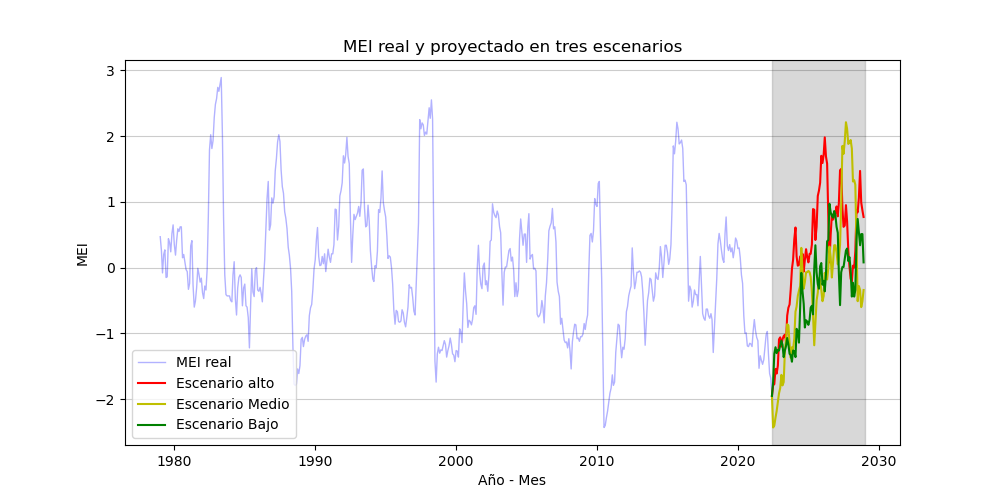

In [14]:
#*******************************************************************************
# 2.4.7. Grafica de escenarios de índices mei.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, \
    hspace=None)
ax1.set_title ('MEI real y proyectado en tres escenarios')
ax1.set_ylabel ('MEI')
ax1.set_xlabel ('Año - Mes')
ax1.plot(meiT.index, meiT.mei, 'b-', label='MEI real', linewidth=1, alpha=0.3)
ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', \
    markersize=2)
ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', \
    markersize=2)
ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', \
    markersize=2)
ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

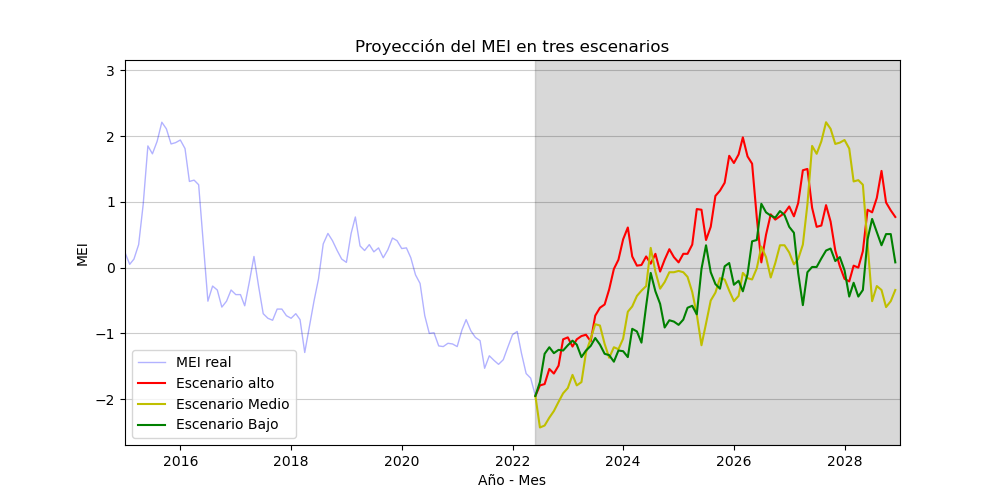

In [16]:
#*******************************************************************************
# 2.4.8 Grafica de detalle de escenarios de índices mei.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, \
    hspace=None)
ax1.set_title ('Proyección del MEI en tres escenarios')
ax1.set_ylabel ('MEI')
ax1.set_xlabel ('Año - Mes')
#ax1.set_xticks(ind, labels=meiL.etiquetaX, rotation=90, fontsize=7)
#plt.xticks(rotation=90)
#
ax1.plot(meiT.index, meiT.mei, 'b-', label='MEI real', linewidth=1, alpha=0.3)
ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', \
    markersize=2)
ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', \
    markersize=2)
ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', \
    markersize=2)
ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.legend(loc='best')
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()